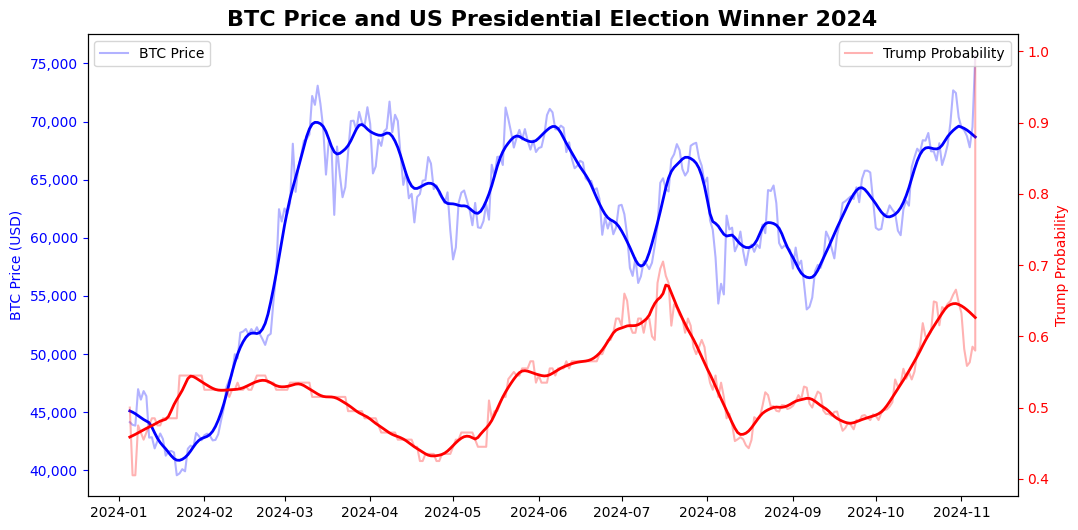

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import statsmodels.api as sm
import numpy as np

sys.path.append("/Users/danieleraimondi/bitcoin_datascience/functions")
from fetch_data import fetch_data


def plot_data(
    include_trump=True,
    include_biden=True,
    include_harris=True,
    include_democrats=True,
    apply_loess=True,
    frac=0.05,
):
    # Fetch and prepare BTC data
    btc = fetch_data("btc")
    btc = btc[["time", "PriceUSD"]]
    btc["time"] = pd.to_datetime(btc["time"])

    # Load and prepare Trump data including Joe Biden and Kamala Harris' probabilities
    trump = pd.read_csv(
        "/Users/danieleraimondi/bitcoin_datascience/data/polymarket_US_election_24.csv"
    )
    trump = trump.drop(columns=["Timestamp (UTC)"]).rename(
        columns={"Date (UTC)": "time"}
    )
    trump["time"] = pd.to_datetime(
        trump["time"], format="%m-%d-%Y %H:%M"
    ).dt.normalize()

    # Merge the BTC data with the Trump data (which includes Biden's and Harris' data)
    merged_data = pd.merge(trump, btc[["time", "PriceUSD"]], on="time", how="inner")

    # Convert time to a numeric format (Unix timestamp) for LOESS
    merged_data["time_numeric"] = (
        merged_data["time"].astype("int64") // 10**9
    )  # Convert to seconds

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # BTC data on primary y-axis in light blue
    ax1.set_ylabel("BTC Price (USD)", color="blue")
    ax1.plot(
        merged_data["time"],
        merged_data["PriceUSD"],
        color="blue",
        label="BTC Price",
        alpha=0.3 if apply_loess else 1.0,  # Set alpha based on LOESS
    )

    # Set thousands separator for y-axis
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    formatter.set_useOffset(False)
    ax1.yaxis.set_major_formatter(formatter)
    ax1.tick_params(axis="y", colors="blue")

    # Use a custom formatting function for thousands separator
    def format_thousands(x, _):
        return f"{int(x):,}"

    ax1.yaxis.set_major_formatter(plt.FuncFormatter(format_thousands))

    # Fit LOESS for BTC Price using the numeric time if apply_loess is True
    if apply_loess:
        lowess_btc = sm.nonparametric.lowess(
            merged_data["PriceUSD"], merged_data["time_numeric"], frac=frac
        )
        lowess_btc_interp = np.interp(
            merged_data["time_numeric"], lowess_btc[:, 0], lowess_btc[:, 1]
        )
        ax1.plot(
            merged_data["time"],
            lowess_btc_interp,
            color="blue",
            linewidth=2,
        )

    # Initialize the secondary y-axis for Trump Probability
    if include_trump:
        ax2 = ax1.twinx()
        ax2.set_ylabel("Trump Probability", color="red")
        ax2.plot(
            merged_data["time"],
            merged_data["Donald Trump"],
            color="red",
            label="Trump Probability",
            alpha=0.3 if apply_loess else 1.0,  # Set alpha based on LOESS
        )
        ax2.tick_params(axis="y", colors="red")

        # Fit LOESS for Trump Probability if apply_loess is True
        if apply_loess:
            lowess_trump = sm.nonparametric.lowess(
                merged_data["Donald Trump"], merged_data["time_numeric"], frac=frac
            )
            lowess_trump_interp = np.interp(
                merged_data["time_numeric"], lowess_trump[:, 0], lowess_trump[:, 1]
            )
            ax2.plot(
                merged_data["time"],
                lowess_trump_interp,
                color="red",
                linewidth=2,
            )

    # Initialize the secondary y-axis for Biden Probability
    ax3 = None
    if include_biden:
        ax3 = ax1.twinx()
        ax3.spines["right"].set_position(("outward", 60))  # Offset the third y-axis
        ax3.set_ylabel("Biden Probability", color="green")
        ax3.plot(
            merged_data["time"],
            merged_data["Joe Biden"],  # Accessing Biden's probability
            color="green",
            label="Biden Probability",
            alpha=0.3 if apply_loess else 1.0,  # Set alpha based on LOESS
        )
        ax3.tick_params(axis="y", colors="green")

        # Fit LOESS for Biden Probability if apply_loess is True
        if apply_loess:
            lowess_biden = sm.nonparametric.lowess(
                merged_data["Joe Biden"], merged_data["time_numeric"], frac=frac
            )
            lowess_biden_interp = np.interp(
                merged_data["time_numeric"], lowess_biden[:, 0], lowess_biden[:, 1]
            )
            ax3.plot(
                merged_data["time"],
                lowess_biden_interp,
                color="green",
                linewidth=2,
            )

    # Initialize the secondary y-axis for Kamala Harris Probability
    ax4 = None
    if include_harris:
        ax4 = ax1.twinx()
        ax4.spines["right"].set_position(("outward", 120))  # Offset the fourth y-axis
        ax4.set_ylabel("Harris Probability", color="purple")
        ax4.plot(
            merged_data["time"],
            merged_data["Kamala Harris"],  # Accessing Harris' probability
            color="purple",
            label="Harris Probability",
            alpha=0.3 if apply_loess else 1.0,  # Set alpha based on LOESS
        )
        ax4.tick_params(axis="y", colors="purple")

        # Fit LOESS for Kamala Harris Probability if apply_loess is True
        if apply_loess:
            lowess_harris = sm.nonparametric.lowess(
                merged_data["Kamala Harris"], merged_data["time_numeric"], frac=frac
            )
            lowess_harris_interp = np.interp(
                merged_data["time_numeric"], lowess_harris[:, 0], lowess_harris[:, 1]
            )
            ax4.plot(
                merged_data["time"],
                lowess_harris_interp,
                color="purple",
                linewidth=2,
            )

    # Initialize the secondary y-axis for Democrat Probability
    if include_democrats:
        ax5 = ax1.twinx()
        ax5.spines["right"].set_position(("outward", 180))  # Offset the fifth y-axis
        ax5.set_ylabel("Democrat Probability", color="orange")
        democrat_prob = merged_data["Joe Biden"] + merged_data["Kamala Harris"]
        ax5.plot(
            merged_data["time"],
            democrat_prob,
            color="orange",
            label="Democrat Probability",
            alpha=0.3 if apply_loess else 1.0,  # Set alpha based on LOESS
        )
        ax5.tick_params(axis="y", colors="orange")

        # Fit LOESS for Democrat Probability if apply_loess is True
        if apply_loess:
            lowess_democrats = sm.nonparametric.lowess(
                democrat_prob, merged_data["time_numeric"], frac=frac
            )
            lowess_democrats_interp = np.interp(
                merged_data["time_numeric"],
                lowess_democrats[:, 0],
                lowess_democrats[:, 1],
            )
            ax5.plot(
                merged_data["time"],
                lowess_democrats_interp,
                color="orange",
                linewidth=2,
            )

    # Adding legends for all axes
    ax1.legend(loc="upper left")
    if include_trump:
        ax2.legend(loc="upper right")
    if include_biden and ax3 is not None:
        ax3.legend(loc="lower right")
    if include_harris and ax4 is not None:
        ax4.legend(loc="lower left")
    if include_democrats and ax5 is not None:
        ax5.legend(loc="center left")

    plt.title(
        "BTC Price and US Presidential Election Winner 2024",
        fontweight="bold",
        fontsize=16,
    )
    plt.show()



plot_data(
    include_trump=True,
    include_biden=False, 
    include_harris=False, 
    include_democrats=False, 
    apply_loess=True,
    frac=0.05,
)